<a href="https://colab.research.google.com/github/smk51/WPS/blob/master/wps_1a_v1_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Water Peace and Security machine learning model**





```
Project: Water Peace and Security Initiative Pillar 1A
Date: April 11, 2019
```
---

*As of April 2019, only some data are ready. This script is meant to serve as a framework to be expanded upon as new data arrives*

In [0]:
# READ IN LIBRARIES
# Python Libraries
from google.colab import auth
import uuid
import pandas as pd
import numpy as np
import itertools
import io
import sys
import scipy
import seaborn as sns
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.utils.fixes import signature
from yellowbrick.features import RFECV
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
# pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

# CONNECT TO CLOUD
# Authenticate Google Cloud Storage
auth.authenticate_user()

# LINK TO GOOGLE BUCKET
# Project ID for WPSI bucket
project_id = 'wpsi-208318'

!gcloud config set project {project_id}

# WPSI bucket name
bucket_name = 'wps_pillar1a'

# Use the GCS Python API to read all the files in our bucket.
!pip install -q google-cloud-storage 
from google.cloud import storage

gcs_client = storage.Client(project=project_id)
bucket = gcs_client.bucket(bucket_name)

# Create a list of all files in the bucket
files = list(bucket.list_blobs())

Updated property [core/project].


In [0]:
# LIST OF FUNCTIONS
def capture_user_selections(lst, variables, variable_names):
  for v in range(0, len(variables)):
    if variables[v] is True:
      lst.append(variable_names[v])
  return lst

# Read files on GCS into Pandas Dataframe (GCS = Google Cloud Storage)
def gcs_to_pandas(file_type):
  # Find the index of the desired file
  file_ind = [files.index(i) for i in files if file_type in str(i)]
  # Select the file
  selected_file = files[file_ind[0]]
  # Download data from file
  file_contents = selected_file.download_as_string()
  # Return contents of file (as string)
  return file_contents

def read_data(filename, head, col): 
  selected_content = gcs_to_pandas(filename)
  df = pd.read_csv(io.BytesIO(selected_content), header=head, index_col = col, encoding='latin-1')
  return df

# # Save data
def save_file(outDF, outname):
  filename_reserved = outname
  outDF.to_csv(filename_reserved)
  !gsutil cp $filename_reserved gs://{bucket_name}/{'data_final'}/{vnumber}/
  !gsutil ls gs://{bucket_name}/{'data_final'}/{vnumber}/
  print('save complete!')

def find_test_dates(allDATA, num, create):
  create = False
  if create == True:
    print("Selecting", num, "random dates")
    alldates = df_filt['run_date'].tolist()
    random_test_dates = random.sample(alldates, num)
    dr = pd.DataFrame(data=random_test_dates, columns=['test_dates'])
    save_file(inFORMAT(vnumber,"input-table-test-dates"))
#         save_file(dr, vnumber+"_test_dates.txt")
  else:
    print("Reading in preselected", num, "random dates")
    dr = read_data(inFORMAT(vnumber,"input-table-test-dates") , 0, None)
    alldates = dr['test_dates'].tolist()
  return alldates

def find_inputs_to_drop():
  filt_ranks = read_data(inFORMAT(vnumber, 'input-feature-selection_rankings'), 0, None)
  if filter_indicators == "none":
    print("Filtering for:", filter_indicators)
    filt_fields = []
  elif filter_indicators == "rfe":
    print("Filtering for:", filter_indicators)
    ff = filt_ranks[filt_ranks['rfe_binary'] == False]
    filt_fields = ff['FieldName'].tolist()
  elif filter_indicators == "eli5":
    print("Filtering for:", filter_indicators)
#     rnk = int(filter_indicators[-2:])
    ff = filt_ranks[filt_ranks['eli5_rank'] > 10]
    filt_fields = ff['FieldName'].tolist()
  elif filter_indicators == "feature_importance":
    print("Filtering for:", filter_indicators)
#     rnk = int(filter_indicators[-2:])
    ff = filt_ranks[filt_ranks['fi_rank'] > 10]
    filt_fields = ff['FieldName'].tolist()
  else:
    print("Filtering for:", filter_indicators)
    ff = filt_ranks[filt_ranks['group_rank'] !=1]
    filt_fields = ff['FieldName'].tolist()
      
  return filt_fields
  


def prepare_historic_data(inFILE):
  # STEP 1 -- READ IN DATA
  # Input table
  df = read_data(inFILE, 0, None)
  df['run_date'] = pd.to_datetime(df['month_start'])

  # STEP 2 -- CLEAN DATA
  # FILTER OUT DATA BASED ON SELECTIONS
  # Remove Islands
  dropiso = ['COM', 'CPV', 'ESH', 'MUS', 'MYT', 'REU', 'SHN', 'STP', 'SYC']
  df = df[~df['gid_0'].isin(dropiso)]

  # Remove Regions based on user selection. Only run if regions are removed
  if regions != ['Africa', 'Asia', 'Middle_East']:
    selected_content = gcs_to_pandas("wps_geometries.csv")
    df_wps = pd.read_csv(io.BytesIO(selected_content), header=0)
    # Filter global data by region list
    df_wps_filt = df_wps[df_wps['REGION'].isin(regions)]
    # Create list of all GID 2s in selection regions
    select_gids = df_wps_filt['GID_2'].tolist()
    df = df[df['gid_2'].isin(select_gids)]

  # Remove training we are not using based on user selection
  dropdependents = ['fatalities', 'count', 'binary', 
                    'fatalities_12m', 'count_12m', 'binary_12m']
  dropdependents.remove(event_type)
  df.drop(dropdependents, axis=1, inplace=True)

  # Remove years based on user selection
  df_filt = df[(df['run_date'] >= datetime.date(start_year, 1, 1)) 
               & (df['run_date'] <= datetime.date(end_year, 12, 1))]

  # Remove indacators based on user selection
  dropping_inputs = find_inputs_to_drop()
  print("Dropping", str(len(dropping_inputs)), "Indicators")
  df_filt.drop(dropping_inputs, axis=1, inplace=True)
  return df_filt

def prepare_current_data(inFILE):
  # STEP 1 -- READ IN DATA
  # Input table
  df = read_data(inFILE, 0, None)
  df['run_date'] = pd.to_datetime(df['month_start'])

  # STEP 2 -- CLEAN DATA
  # FILTER OUT DATA BASED ON SELECTIONS
  # Remove Islands
  dropiso = ['COM', 'CPV', 'ESH', 'MUS', 'MYT', 'REU', 'SHN', 'STP', 'SYC']
  df = df[~df['gid_0'].isin(dropiso)]

  # Remove Regions based on user selection. Only run if regions are removed
  if regions != ['Africa', 'Asia', 'Middle_East']:
    selected_content = gcs_to_pandas("wps_geometries.csv")
    df_wps = pd.read_csv(io.BytesIO(selected_content), header=0)
    # Filter global data by region list
    df_wps_filt = df_wps[df_wps['REGION'].isin(regions)]
    # Create list of all GID 2s in selection regions
    select_gids = df_wps_filt['GID_2'].tolist()
    df = df[df['gid_2'].isin(select_gids)]

  # Remove indacators based on user selection
  dropping_inputs = find_inputs_to_drop()
  print("Dropping", str(len(dropping_inputs)), "Indicators")
  df.drop(dropping_inputs, axis=1, inplace=True)
  return df

def balance_binary(inDATA, train_field, ratio_ceiling):
  # Separate dependent variable into yes's and no's
  df_0_all = inDATA[inDATA[train_field]==0]
  df_1_all = inDATA[inDATA[train_field]==1]
  n_0 = len(df_0_all)
  n_1 = len(df_1_all)
  print("Number of no events:", str(n_0), "Number of events:", str(n_1))

  # set maximum number of samples in any one category, relative to smallest category
  n_min = min(n_0, n_1)
  n_ceiling = int(ratio_ceiling * n_min)

  print ("Minimum group size:", str(n_min))
  print ("Ceiling:", str(n_ceiling))

  if n_1 <= n_ceiling:
    df_1_trimmed = df_1_all.copy()
  else:
    df_1_trimmed = df_1_all.sample(n=n_ceiling)


  if n_0 <= n_ceiling:
    df_0_trimmed = df_0_all.copy()
  else:
    df_0_trimmed = df_0_all.sample(n=n_ceiling)

  frames = [df_1_trimmed, df_0_trimmed]

  df_balanced = pd.concat(frames)
  print ("Size of balanced dataset:", len(df_balanced))
  return df_balanced

def train_vs_test(allDATA, test_dates):
  df_u = allDATA[~allDATA['run_date'].isin(test_dates)] # Select all data EXCEPT test year
  df_t = allDATA[allDATA['run_date'].isin(test_dates)] 
  print("Train with:", str(len(df_u)), "Test with:", str(len(df_t)))
  return df_u, df_t

def create_X_y(inDATA, train_field):
  Xx = inDATA.drop([train_field, 'gid_2', 'gid_0', 'run_date', 'month_start', 'month_indep'], axis=1)
  yy = inDATA.filter([train_field])
  return Xx, yy

In [0]:
#@title # Training Data Parameters
#@markdown *Tip: Don't forget to run code block after you've made your selections*

#@markdown ## Select event statistic
#@markdown Choose between number of fatalities, number of events, or yes/no events
#@markdown (12m means over the next year; else, just that month)
event_type = "binary_12m" #@param ["fatalities_12m", "count_12m", "binary_12m", "fatalities", "count", "binary"]


#@markdown ## Select date range
#@markdown First year of training dataset (cannot be before 2004)
start_year = 2004 #@param {type:"slider", min:2004, max:2017, step:1}
#@markdown Last year of training dataset (cannot be before start year or after 2018)
end_year = 2018 #@param {type:"slider", min:2004, max:2018, step:1}


regions = []

#@markdown ## Select regions
Africa = True #@param {type:"boolean"}
Asia = True #@param {type:"boolean"}
Middle_East = True #@param {type:"boolean"}
Europe = False

regions = capture_user_selections(regions, [Africa, Asia, Middle_East], 
                               ['Africa', 'Asia', 'Middle_East'])

#@markdown ## Filter input indicators
filter_indicators = "best_in_group" #@param ["none", "rfe", "eli5", "feature_importance", "best_in_group"]



### **Prepare the data**

In [0]:

# Read and Write information
vnumber = 'v1_201904'
inFORMAT = '{:s}_{:s}.csv'.format
outFORMAT = '{:s}_results_{:s}_{:s}.csv'.format
featFORMAT = '{:s}_feature-selection_{:s}_{:s}.csv'.format

# STEP 1 - PREPARE DATASETS
# Prep data to train & test model
df_historic = prepare_historic_data(inFORMAT(vnumber, 'input-table-historic'))
# Prep data to predict in the future
df_current = prepare_current_data(inFORMAT(vnumber, 'input-table-current'))

# STEP 2 - SEPARATE OUT DATA FOR TRAINING VS TESTING
# Define dates to withhold
random_test_dates = find_test_dates(df_historic, 12, False) 
df_train, df_test = train_vs_test(df_historic, random_test_dates)

# STEP 3 - BALANCE TRAINING DATA
df_b = balance_binary(df_train, event_type, 2.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


Filtering for: best_in_group
Dropping 61 Indicators
Filtering for: best_in_group
Dropping 61 Indicators
Reading in preselected 12 random dates
Train with: 1239668 Test with: 95268
Number of no events: 1096111 Number of events: 143557
Minimum group size: 143557
Ceiling: 287114
Size of balanced dataset: 430671


### **Create the model**


In [0]:
# CREATE MODEL!!!

# Break historic data into train and validate datasets
Xh, yh = create_X_y(df_b, event_type)

X_train, X_validate, y_train, y_validate = train_test_split(Xh, yh, test_size=0.2, random_state=5)

# Set up model
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456,
                           class_weight="balanced" ) #{0:10000, 1:1, 2:1} )
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=True,
            random_state=123456, verbose=0, warm_start=False)

### **Train, validate, and test the model**

In [0]:

# TEST MODEL ON VALIDATION AND TEST DATA
# Training data

y_train_pred = rf.predict(X_train)
print('# training samples: ' + str(len(y_train)))
print('model score on training data: ' + str(rf.score(X_train, y_train)))
# Validation data
y_validate_pred = rf.predict(X_validate)
accuracy_v = accuracy_score(y_validate, y_validate_pred)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy of validation: {accuracy_v:.3}')

# Test data
# removing bad values in simplistic manner
X_test, y_test = create_X_y(df_test, event_type)

# Run binary analysis
y_test_pred = rf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy of test: {accuracy_test:.3}')
# Add binary prediction to dataframe
se = pd.Series(y_test_pred)
df_results = df_test.copy()
df_results['prediction'] = se.values

# Run probability analysis
y_test_pred_prob = rf.predict_proba(X_test)
# Add binary prediction to dataframe
z = y_test_pred_prob[:,1]
se = pd.Series(z)
df_results['prediction_prob'] = se.values
# Save results
save_file(df_results, outFORMAT(vnumber, "test", filter_indicators))

# Save accuracies
accs = pd.DataFrame.from_dict({'training': [str(rf.score(X_train, y_train))], 
                     'validation': [str(accuracy_v)], 
                     'testing':[str(accuracy_test)]})

save_file(accs, outFORMAT(vnumber, "accuracies", filter_indicators))

# training samples: 344536
model score on training data: 0.9999970975456847
Out-of-bag score estimate: 0.965
Mean accuracy of validation: 0.966
Out-of-bag score estimate: 0.965
Mean accuracy of test: 0.972
Copying file://v1_201904_results_test_best_in_group.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/24.8 MiB.                                     
gs://wps_pillar1a/data_final/v1_201904/
gs://wps_pillar1a/data_final/v1_201904/_README.txt
gs://wps_pillar1a/data_final/v1_201904/v1_201904_current_template.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_feature-selection-RFE_none.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_feature-selection_eli5-perumation-importance_none.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-feature-selection_rankings.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-table-current.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-table-historic.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_i

### **Predict conflict using current data**

In [0]:
# Select all indicators
Xc = df_current.drop(['gid_2','gid_1', 'gid_0', 'run_date', 'month_start', 'month_indep', 'year', 'month', 'day'], axis=1)

# Run binary analysis
y_current_pred = rf.predict(Xc)
y_current_pred_prob = rf.predict_proba(Xc)
# Add binary prediction to dataframe
sepred = pd.Series(y_current_pred)
zc = y_current_pred_prob[:,1]
seprob = pd.Series(zc)
df_res_current = df_current.copy()
df_res_current['prediction'] = sepred.values
df_res_current['prediction_prob'] = seprob.values

save_file(df_res_current, outFORMAT(vnumber, "future", filter_indicators))


Copying file://v1_201904_results_future_best_in_group.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/25.4 MiB.                                     
gs://wps_pillar1a/data_final/v1_201904/
gs://wps_pillar1a/data_final/v1_201904/_README.txt
gs://wps_pillar1a/data_final/v1_201904/v1_201904_current_template.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_feature-selection-RFE_none.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_feature-selection_eli5-perumation-importance_none.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-feature-selection_rankings.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-table-current.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-table-historic.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-table-test-dates.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_results_accuracies_best_in_group.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_results_accuracies_none.csv
gs://wps_pillar

Text(0.5, 1.0, 'v1_201904 best_in_group')

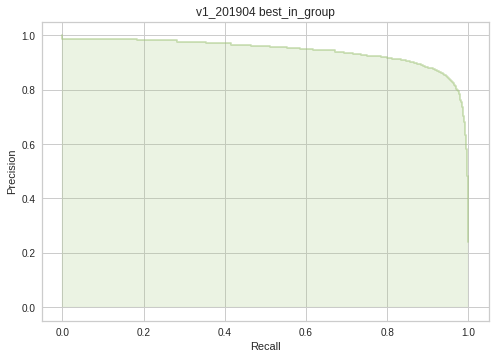

In [0]:
# Precision vs Recall 

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_prob[:,1])
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='g', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(vnumber+ " " + filter_indicators)

In [0]:
# # create score
# import pickle
# filename = 'rfecv_model.sav'




ftwo_scorer = make_scorer(fbeta_score, beta=2)
oz = RFECV(rf, scoring=ftwo_scorer) # f2_weighted
# pickle.dump(oz, open(filename, 'wb'))
print('eliminator created')
# oz = pickle.load(open(filename, 'rb'))
oz.fit(Xh, yh)
oz.poof()
  


eliminator created


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
# PERMUTATION IMPORTANCE

# perm = PermutationImportance(rf).fit(X_test, y_test)
# eli5.show_weights(perm)


# Turn results into dataframe
p = eli5.explain_weights_df(perm)
p['rank'] = range(1, len(p)+1)
# Create lookup table of fields
inds = X_test.columns.to_frame(name='Fields').reset_index()
inds['ids'] = ["x"+str(x) for x in range(0, len(inds))]
inds.drop(['index'], axis=1, inplace=True)
inds['featureimportance'] = rf.feature_importances_ 
# Add file names to results
df_p = pd.merge(p, inds, how='left', left_on = 'feature', right_on='ids')
df_p
# Save
save_file(df_p, featFORMAT(vnumber, "eli5-perumation-importance", filter_indicators))

Copying file://v1_201904_feature-selection_eli5-perumation-importance_best_in_group.csv [Content-Type=text/csv]...
/ [1 files][  1.7 KiB/  1.7 KiB]                                                
Operation completed over 1 objects/1.7 KiB.                                      
gs://wps_pillar1a/data_final/v1_201904/
gs://wps_pillar1a/data_final/v1_201904/_README.txt
gs://wps_pillar1a/data_final/v1_201904/v1_201904_current_template.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_feature-selection-RFE_none.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_feature-selection_eli5-perumation-importance_best_in_group.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_feature-selection_eli5-perumation-importance_none.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-feature-selection_rankings.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-table-current.csv
gs://wps_pillar1a/data_final/v1_201904/v1_201904_input-table-historic.csv
gs://wps_pillar1a/data_final/v1_2

In [0]:
inds

,Fields,ids,featureimportance
0,loccount,x0,0.050936
1,locdensity,x1,0.034002
2,age_0-14,x2,0.019184
3,age_15-24,x3,0.010049
4,age_25-64,x4,0.012866
5,age_65+,x5,0.010838
6,sex_0-14,x6,0.015773
7,sex_15-24,x7,0.015715
8,sex_25-64,x8,0.017661
9,sex_65+,x9,0.012333


In [0]:
df_p.sort_values('')

,feature,weight,std,rank,Fields,ids
0,x0,0.009462,0.000232,1,loccount,x0
1,x11,0.003260,0.000162,2,rurpop,x11
2,x1,0.002989,0.000167,3,locdensity,x1
3,x49,0.002947,0.000087,4,Violence_against_civilians_count_12months,x49
4,x46,0.002526,0.000070,5,Battles_count_12months,x46
5,x33,0.002498,0.000115,6,cep,x33
6,x27,0.002456,0.000063,7,et_anom_year,x27
7,x43,0.001829,0.000060,8,Violence_against_civilians_fatalities_12months,x43
8,x37,0.001751,0.000058,9,rvr,x37
9,x55,0.001738,0.000140,10,Violence_against_civilians_binary_12months,x55


In [0]:
inds

,Fields,ids
0,loccount,X1
1,locdensity,X2
2,age_0-14,X3
3,age_15-24,X4
4,age_25-64,X5
5,age_65+,X6
6,sex_0-14,X7
7,sex_15-24,X8
8,sex_25-64,X9
9,sex_65+,X10
